# Clustering

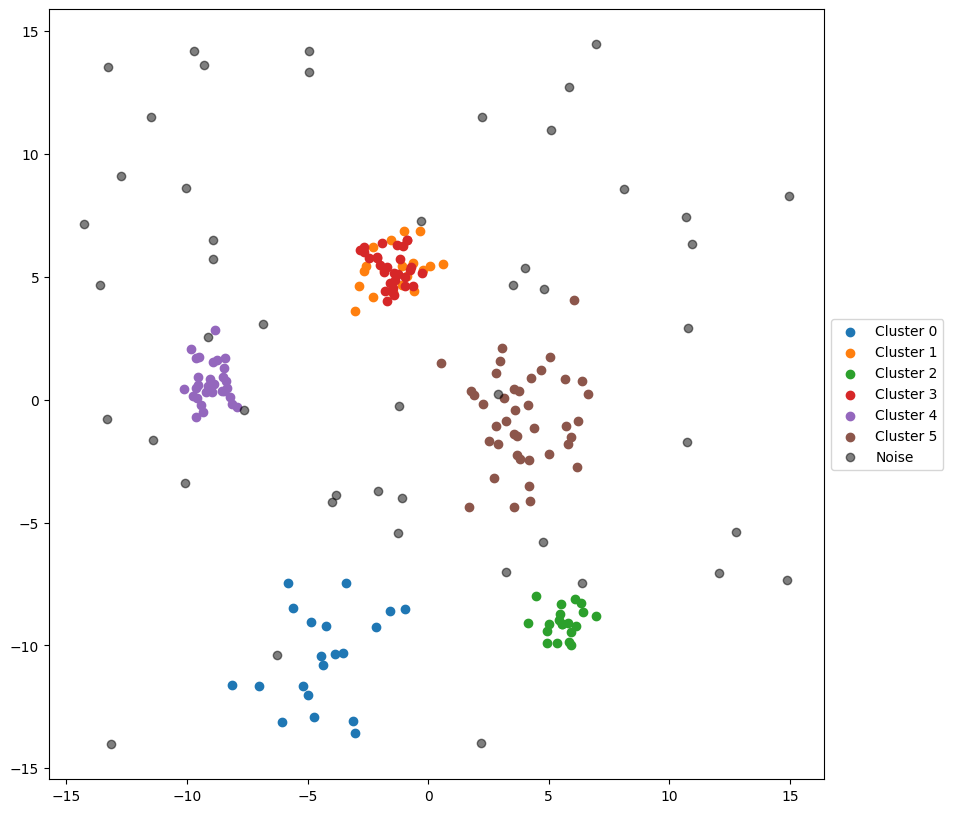

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# genero i dati:
N = 6
n_points = [20, 20, 20, 30, 30, 40]
noise_w = 0.3
# scelgo casualmente in [-10,10]x[-10,10] N centroidi a valori reali
centroids = np.random.rand(N, 2) * 20 - 10
# stabilisco delle varianze casuali per questi centroidi tra [0.5, 2]
variances = np.random.rand(N) * 1.5 + 0.5
# stabilisco il numero di punti per ogni cluster
# genero i punti
data = [np.random.randn(n, 2) * variances[i] + centroids[i] for i, n in enumerate(n_points)]

# inserisco del rumore: aggiungo dei punti uniformemente distribuiti in [-15,15]*[-15,15]
noise = np.random.rand(int(noise_w*sum(n_points)), 2) * 30 - 15

# plotto tutto
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(N):
    ax.scatter(data[i][:, 0], data[i][:, 1], label='Cluster %d' % i)

ax.scatter(noise[:, 0], noise[:, 1], label='Noise', c='black', alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


## KMeans algorithm

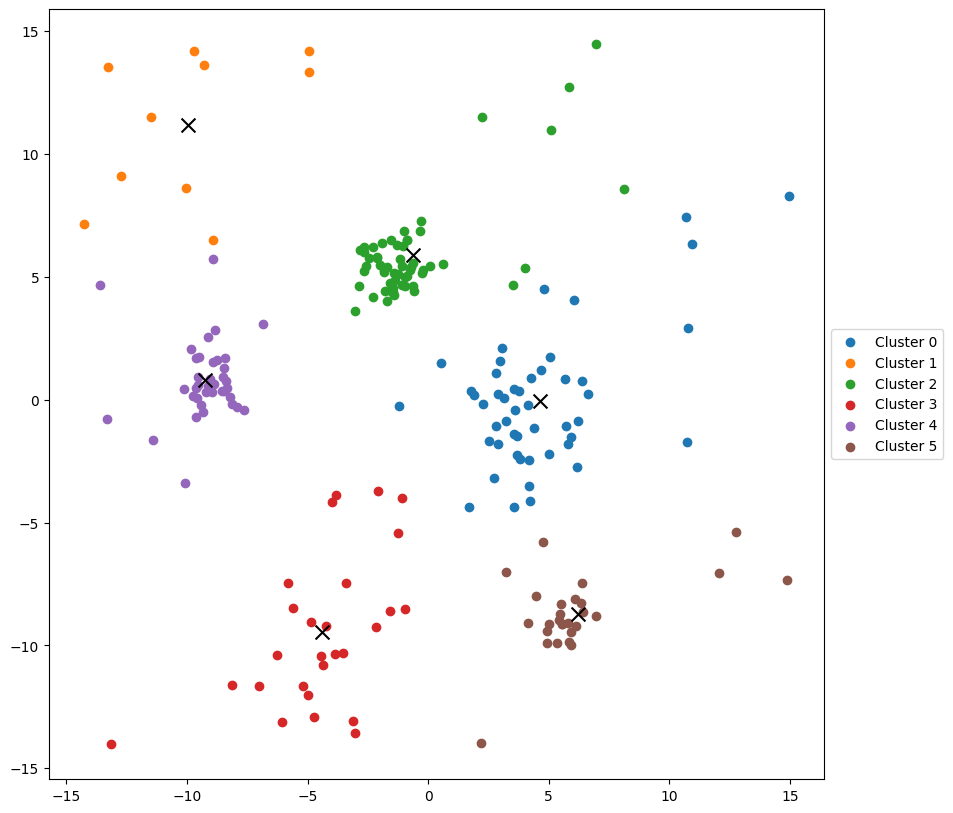

In [118]:
# eseguo il classico KMeans
from sklearn.cluster import KMeans

fused_data = np.concatenate(data + [noise])
kmeans = KMeans(n_clusters=N, init='k-means++', max_iter=1000)
kmeans.fit(fused_data)
labels = kmeans.predict(fused_data)

# plotto i risultati:
# i centroidi sono indicati con una x e i dati con dei cerchi
# il colore di un cluster è dettato dal label stimato con kmeans
plt.figure(figsize=(10, 10))
for i in range(N):
    plt.scatter(fused_data[labels == i][:, 0], fused_data[labels == i][:, 1], label='Cluster %d' % i)
    plt.scatter(kmeans.cluster_centers_[i][0], kmeans.cluster_centers_[i][1], marker='x', s=100, c='black')

# la legenda la voglio fuori dal plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Gaussian Mixture Clustering

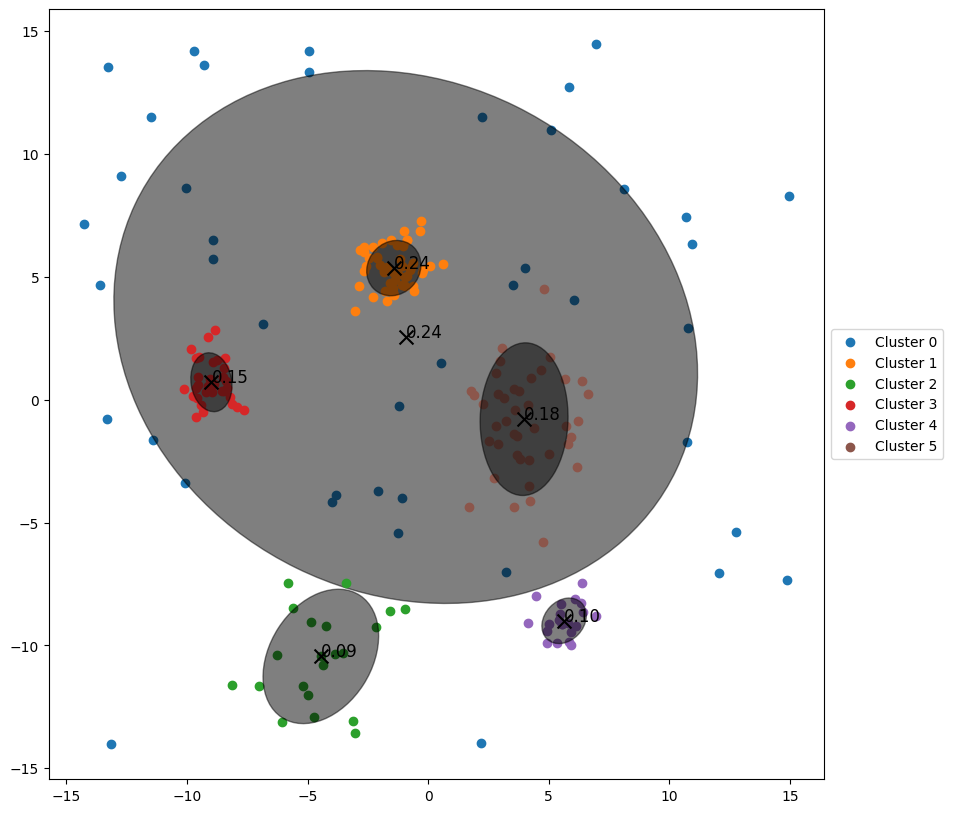

In [127]:
# eseguo il Gaussian Mixture Model
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

n_clusters = 6
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', init_params='kmeans', max_iter=1000, tol=1e-6)

gmm.fit(fused_data)
labels = gmm.predict(fused_data)

# plotto i risultati:
# i centroidi sono indicati con una x e i dati con dei cerchi
# il colore di un cluster è dettato dal label stimato con gmm
# indico con un'ellisse la covarianza del cluster
# indico il peso del cluster con un numero vicino al centroide
plt.figure(figsize=(10, 10))
for i in range(N):
    plt.scatter(fused_data[labels == i][:, 0], fused_data[labels == i][:, 1], label='Cluster %d' % i)
    plt.scatter(gmm.means_[i][0], gmm.means_[i][1], marker='x', s=100, c='black')
    # inserisco l'ellisse
    cov = gmm.covariances_[i]
    v, w = np.linalg.eigh(cov)
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180 * angle / np.pi
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = Ellipse(xy=gmm.means_[i], width=v[0], height=v[1], angle=180 + angle, color='black', alpha=0.5)
    plt.gca().add_patch(ell)
    # peso del cluster
    plt.text(gmm.means_[i][0], gmm.means_[i][1], '%.2f' % gmm.weights_[i], fontsize=12)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## FCM algorithm

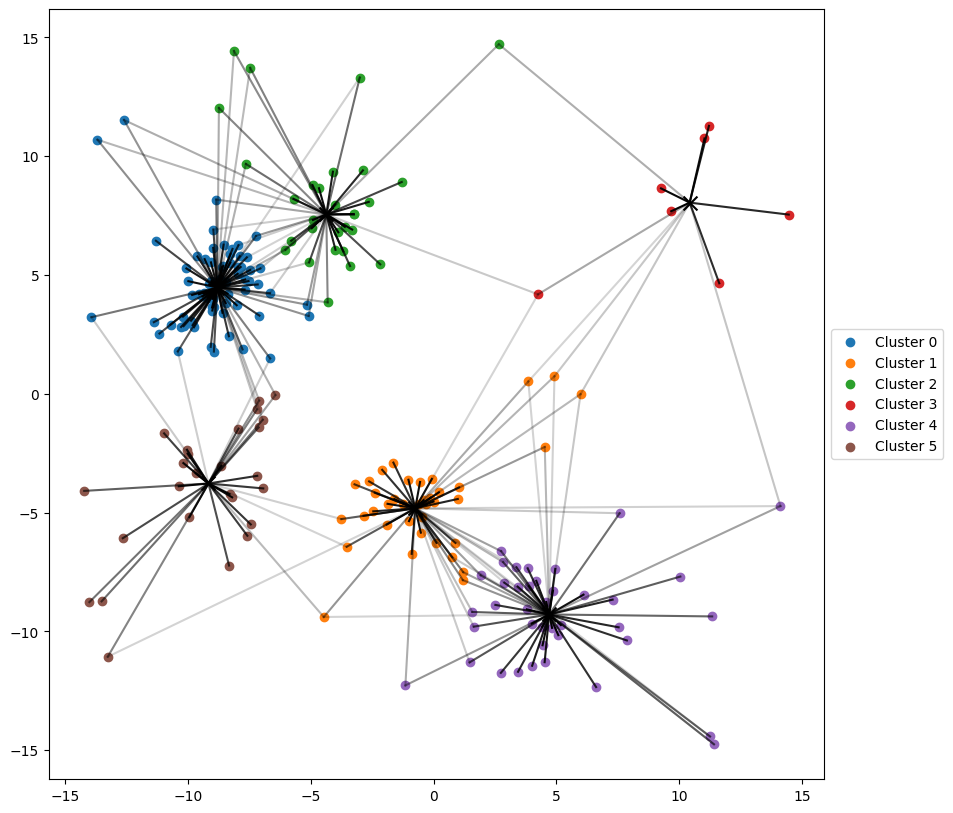

In [33]:
# eseguo la clusterizzazione FCM usando torch

# importo da matplotlib le linee
from matplotlib.lines import Line2D
import torch
# setto il device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# con kmeans stabilisco i centroidi iniziali
kmeans = KMeans(n_clusters=N, init='k-means++', max_iter=1000)
kmeans.fit(fused_data)
centroids = kmeans.cluster_centers_

# calcolo la matrice delle distanze a 2 a 2 tra dati e centroidi
data_torch = torch.tensor(fused_data, device=device)
centroids = torch.tensor(centroids, device=device)
m = 2

for i in range(10000):
    distances = torch.cdist(data_torch, centroids) ** (2/(m-1))
    # calcolo la matrice di membership
    U = 1 / (distances * torch.sum(1 / distances, dim=1, keepdim=True))

    # calcolo i nuovi centroidi
    Um = U ** m
    centroids = torch.matmul(Um.T, data_torch) / torch.sum(Um, dim=0, keepdim=True).T

# plotto i risultati:
# i centroidi sono indicati con una x e i dat9i con dei cerchi
# il colore di un cluster è dettato dal label stimato con fcm (argmax)
# il valore di tale collegamente è indicato con una linea tanto più chiara quanto più è basso
plt.figure(figsize=(10, 10))
labels = torch.argmax(U, dim=1)

# passo a numpy per poter usare le funzioni di matplotlib
labels = labels.cpu().numpy()
centroids = centroids.cpu().numpy()
U = U.cpu().numpy()
for i in range(N):
    plt.scatter(fused_data[labels==i][:,0], fused_data[labels==i][:,1], label='Cluster %d' % i)
    plt.scatter(centroids[i,0], centroids[i,1], marker='x', s=100, c='black')
for j in range(len(fused_data)):
    middle = 1./len(centroids)
    for i in range(N):
        if U[j,i] >= middle:
            line = Line2D(
                [fused_data[j,0], centroids[i,0]],
                [fused_data[j,1], centroids[i,1]],
                alpha=U[j,i],
                color='black',
            )
            plt.gca().add_line(line)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
    

# Cleaning and gray scale

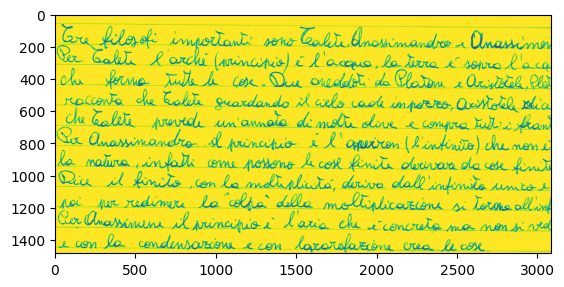

In [59]:
from PIL import Image
from matplotlib import pyplot as plt

# leggo un'immagine non preprocessata
img = Image.open("data/db/cutted_set/Author2/Author2_0001_01.png").convert("L")

# mostro l'immagine a schermo
plt.imshow(img)
plt.show()

Studio la densità dei grigi nell'immagine

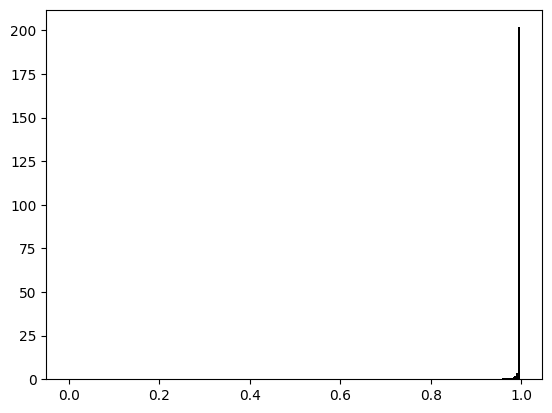

In [60]:
import numpy as np

# la converto in un array numpy
img_array = np.array(img, dtype=np.float32)/256.0

# mostro un grafico con la densità in scala di grigi
# sull'ascisse un valore tra 0 e 1, sull'ordinata il numero di pixel con quel valore
plt.hist(img_array.flatten(), bins=256, color='black', density=True)
plt.show()

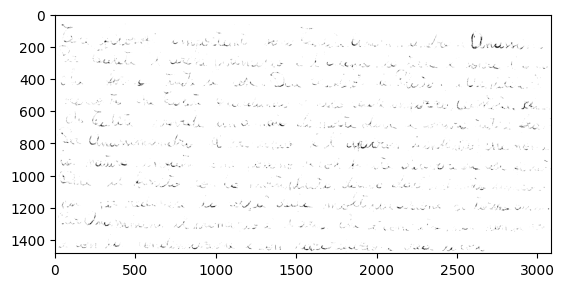

In [64]:
# taglio i colori in base al loro valore rispetto un threshold
threshold = 0.25
img_array_cut = np.zeros_like(img_array)
img_array_cut[img_array < threshold] = 0
img_array_cut[img_array >= threshold] = 1

# mostro l'immagine a schermo
plt.imshow(img_array_cut, cmap='gray')
plt.show()

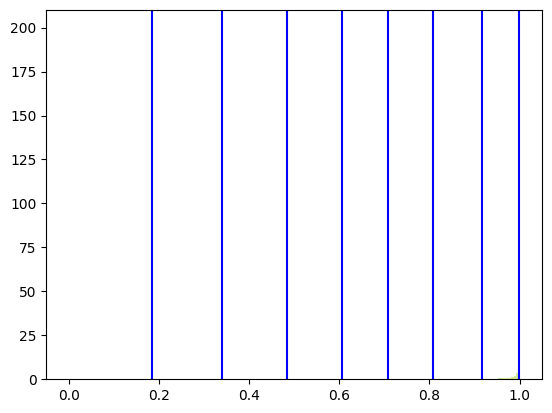

In [25]:
from sklearn.cluster import KMeans

# eseguo una clusterizzazione kmeans su tutti i valori tra 0 e 1 con n_centroids
n_centroids = 8
img_flat = img_array.reshape(-1, 1)
kmeans = KMeans(n_clusters=n_centroids, init='k-means++', max_iter=1000)
kmeans.fit(img_flat)
labels = kmeans.predict(img_flat)
centroids = kmeans.cluster_centers_

# controllo che il numero di iterazioni non abbia superato max_iter
if kmeans.n_iter_ == kmeans.max_iter:
    print('KMeans non ha convergenza')

# riodino i centroidi e i labels in ordine crescente
order = np.argsort(centroids.flatten())
centroids = centroids[order]
new_labels = np.zeros_like(labels)
for i, o in enumerate(order):
    new_labels[labels == o] = i
labels = new_labels

# Normalize labels to range [0, 1]
normalized_labels = labels / labels.max()

# Create a colormap
cmap = plt.get_cmap('viridis')

# Plot histogram for each cluster
hist, bin_edges = np.histogram(img_array.flatten(), bins=256, density=False)
for i in range(n_centroids):
    cluster_data = img_flat[labels == i]
    cluster_hist, _ = np.histogram(
        cluster_data,
        bins=bin_edges,
        density=False
    )
    plt.hist(
        bin_edges[:-1],
        bins=bin_edges,
        weights=cluster_hist / hist.sum() * 256,
        color=cmap(i / n_centroids),
        alpha=0.5,
    )

# Add vertical lines for centroids
for c in centroids:
    plt.axvline(c, color='blue')

plt.show()

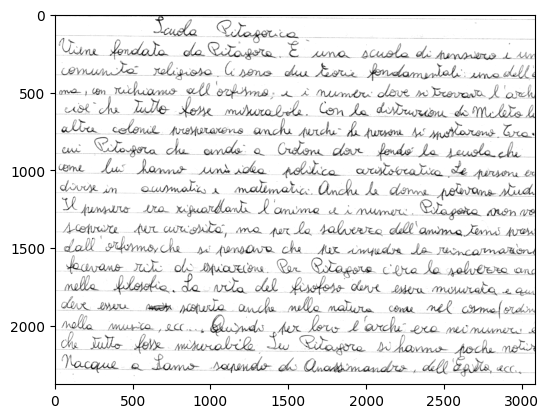

In [26]:
# ricostruisco l'immagine originale usando i centroidi
img_reconstructed = centroids[labels].reshape(img_array.shape)

# mostro l'immagine ricostruita
plt.imshow(img_reconstructed, cmap='gray')
plt.show()

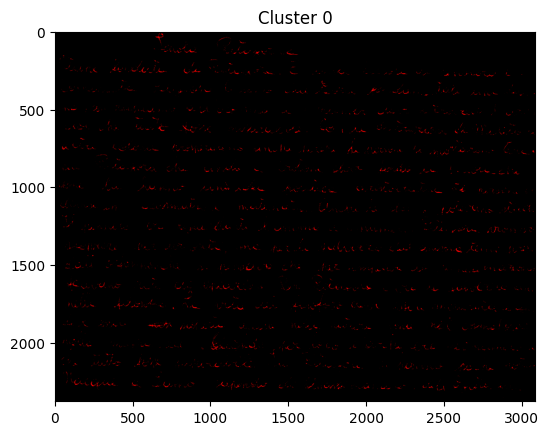

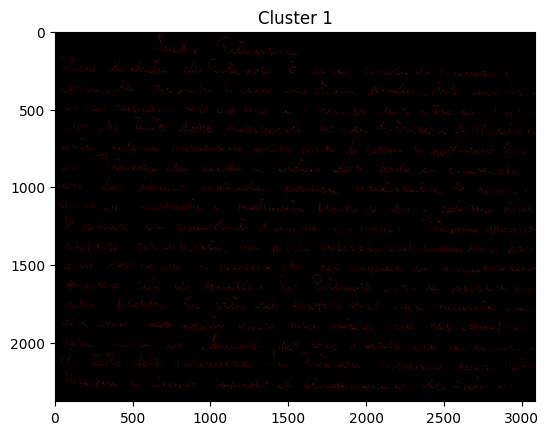

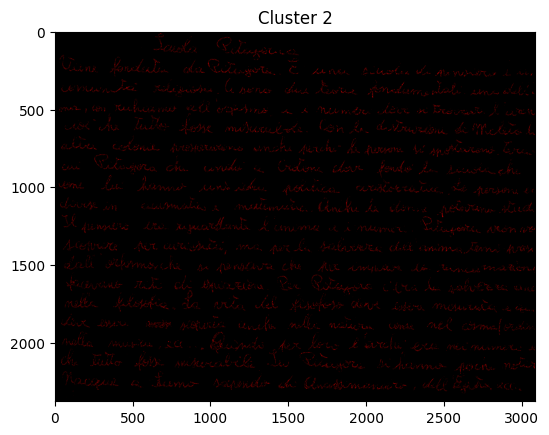

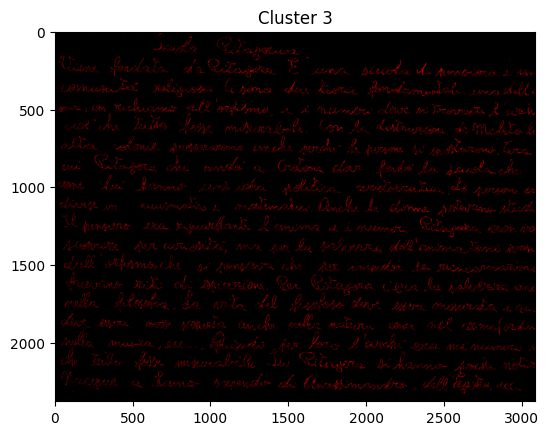

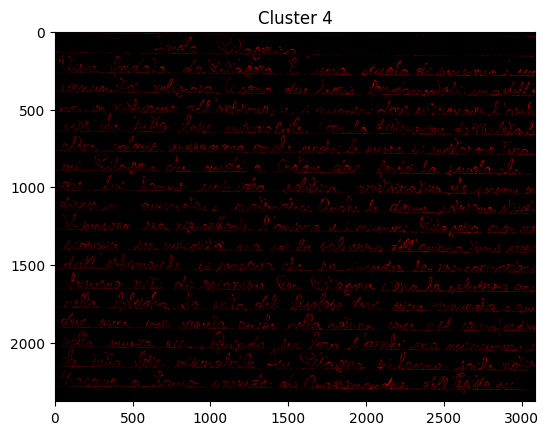

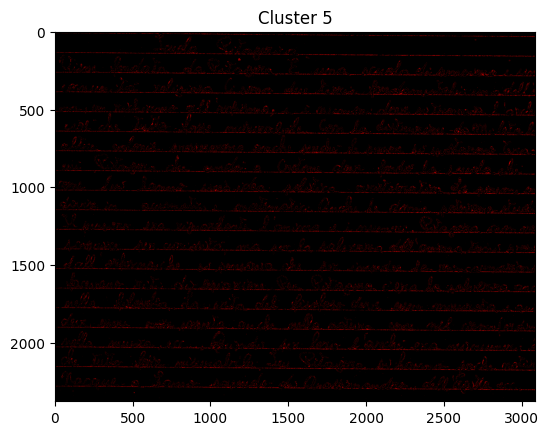

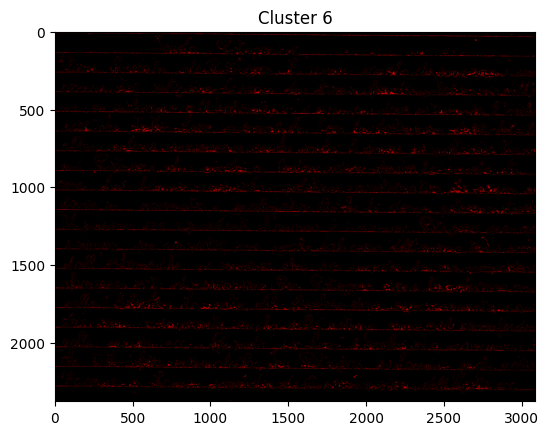

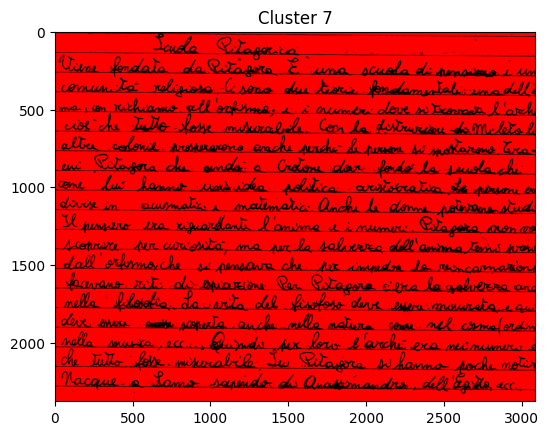

In [27]:
# nell'immagine faccio sì che i pixel del cluster k-esimo siano colorati di rosso

# cluster scelto
for k in range(n_centroids):
    # creo un'immagine vuota
    img_colored = np.zeros(img_array.shape + (3,))
    # coloro i pixel del cluster k-esimo di rosso
    img_colored_flat = img_colored.reshape(-1, 3)
    img_colored_flat[labels == k] = [1, 0, 0]
    img_colored = img_colored_flat.reshape(img_array.shape + (3,))

    # riproduco l'immagine
    plt.imshow(img_colored)
    plt.title('Cluster %d' % k)
    plt.show()


In [34]:
# normalizzo l'immagine affinché solo i claster da A a B siano visibili (con valori tra 0 e 1)

# scritte in 14-20/64

A = 0
B = 5
# cerco il colore del pixel dentro il cluster A di valore minimo
min_A = img_flat[labels == A].min()
max_B = img_flat[labels == B].max()
img_normalized = (img_array - min_A) / (max_B - min_A)
# taglio i valori < 0 a 0 e i valori > 1 a 1
img_normalized[img_normalized < 0] = 0
img_normalized[img_normalized > 1] = 1

# salvo l'immagine come png
img_normalized = Image.fromarray(np.uint8(img_normalized*255))
img_normalized.save('data/out/normalized.png')

# Distanza tra distribuzioni

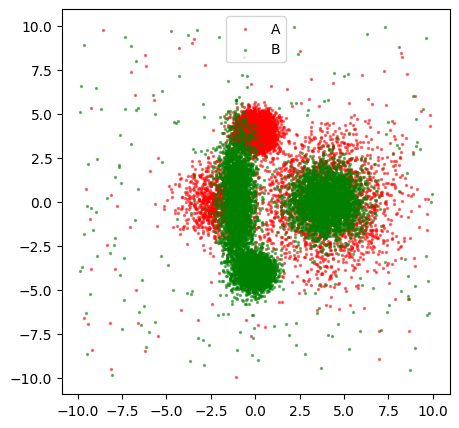

In [81]:
# le due distribuzioni prese in esame sono due normali con varianza 1 e media -1 e 1
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

A_1 = torch.randn(1_000, 2, device=device) + torch.tensor([-2, 0], device=device)
A_2 = torch.randn(2_000, 2, device=device) * 2 + torch.tensor([4, 0], device=device)
A_3 = torch.randn(5_000, 2, device=device) * 0.5 + torch.tensor([0, 4], device=device)
A_noise = torch.rand(100, 2, device=device) * 20 - 10
# concateno i dati
A = torch.cat([A_1, A_2, A_3, A_noise], dim=0)
w_A = torch.ones(A.shape[0], device=device)/A.shape[0]

B_1 = torch.randn(3_000, 2, device=device) * torch.tensor([0.5, 2], device=device) + torch.tensor([-1, 0], device=device)
B_2 = torch.randn(3_000, 2, device=device) + torch.tensor([4, 0], device=device)
B_3 = torch.randn(3_000, 2, device=device) * 0.5 + torch.tensor([0, -4], device=device)
B_noise = torch.rand(200, 2, device=device) * 20 - 10
# concateno i dati
B = torch.cat([B_1, B_2, B_3, B_noise], dim=0)
w_B = torch.ones(B.shape[0], device=device)/B.shape[0]

# plotto i dati in 3d
plt.figure(figsize=(5, 5))
plt.scatter(A[:, 0].cpu(), A[:, 1].cpu(), label='A', alpha=0.5, s=2, color='red')
plt.scatter(B[:, 0].cpu(), B[:, 1].cpu(), label='B', alpha=0.5, s=2, color='green')
plt.legend()
plt.show()

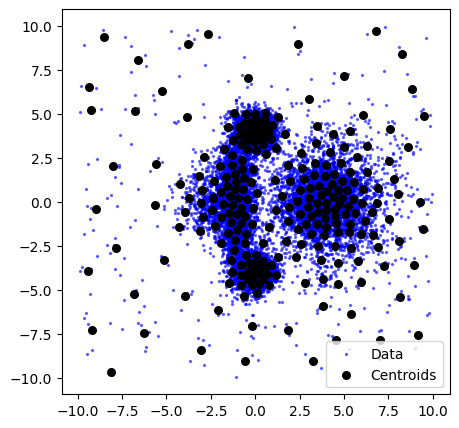

In [142]:
from sklearn.cluster import KMeans

# eseguo una clusterizzazione kmeans sulla fusione dei dati considerando i pesi
fused_d = torch.cat([A, B])
fused_w = torch.cat([w_A, w_B])
n_clusters = 256

fused_d = fused_d.view(-1, fused_d.shape[-1])
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000)

fit = kmeans.fit(fused_d.cpu().numpy(), sample_weight=fused_w.cpu().numpy())

centers = torch.from_numpy(fit.cluster_centers_).to(device=device)

# plot dei centroidi (o neri) assieme alla distribuzione dei dati (scatter blu)
plt.figure(figsize=(5, 5))
plt.scatter(fused_d[:, 0].cpu(), fused_d[:, 1].cpu(), s=2, alpha=0.5, color='blue', label='Data')
plt.scatter(centers[:, 0].cpu(), centers[:, 1].cpu(), s=30, color='black', marker='o', label='Centroids')
plt.legend()
plt.show()

/home/stefano/Documents/GitHub/MMATH_thesis/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


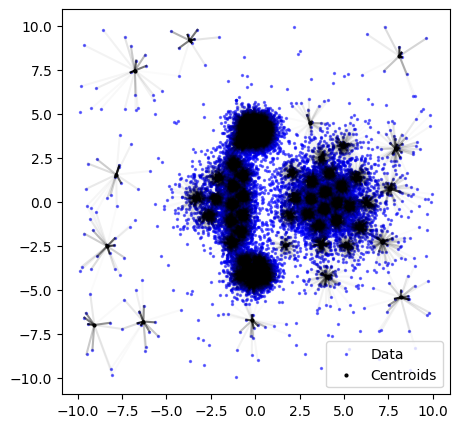

In [131]:
# uso centroids come initial centroids per fcm
iter = 10
fcm_centers = centers.clone()
for i in range(iter):
    distances = torch.cdist(fused_d, fcm_centers) ** 2
    
    # eseguo operazioni distinte su ogni riga di distances:
    # se la riga contiene uno 0 allora setto 1 dove ci sono 0 e 0 altrove
    # altrimenti calcolo la membership
    special_rows = torch.any(distances == 0, dim=1, keepdim=True)
    min_values = torch.min(distances, dim=1)[0]
    U = torch.where(special_rows, 
        distances != 0, # if row contains 0, set 1 where 0 and 0 elsewhere
        min_values[:,None] / distances, # else calculate membership
    )
    U = (U / U.sum(dim=1, keepdim=True))**2
    fcm_centers = torch.matmul(U.T, fused_d) / torch.sum(U, dim=0, keepdim=True).T

centers = fcm_centers.clone()
# plot dei centroidi (o neri) assieme alla distribuzione dei dati (scatter blu)
plt.figure(figsize=(5, 5))
plt.scatter(fused_d[:, 0].cpu(), fused_d[:, 1].cpu(), s=2, alpha=0.5, color='blue', label='Data')
plt.scatter(centers[:, 0].cpu(), centers[:, 1].cpu(), s=4, color='black', marker='o', label='Centroids')
# aggiungo le linee di membership, se la membership è superiore a 1/n_clusters inserisco una linea
indices = torch.where(U >= 1./n_clusters)
for i in range(len(indices[0])):
    plt.plot(
        [fused_d[indices[0][i], 0].cpu(), centers[indices[1][i], 0].cpu()],
        [fused_d[indices[0][i], 1].cpu(), centers[indices[1][i], 1].cpu()],
        color='black', alpha=U[indices[0][i], indices[1][i]].cpu().item()
    )
plt.legend()
plt.show()

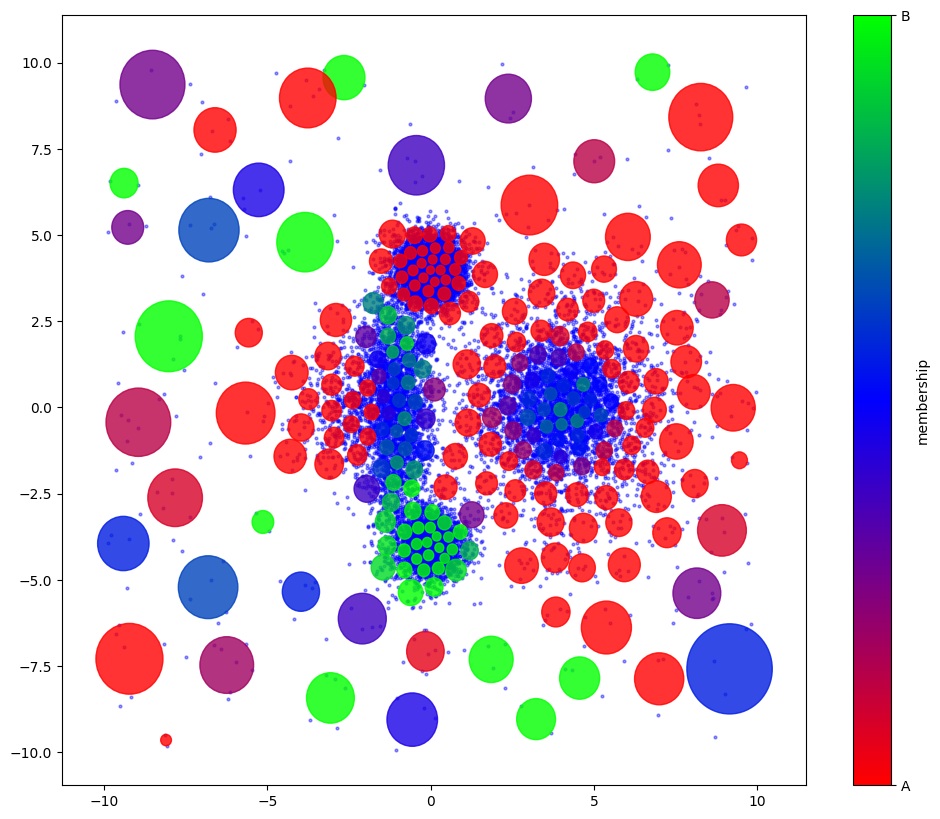

In [143]:
from matplotlib.patches import Circle
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

# se si usa kmeans U[i,j] = 1 se il punto i è nel cluster j altrimenti 0
labels = kmeans.predict(fused_d.cpu().numpy())
U = torch.zeros(fused_d.shape[0], n_clusters, device=device)
for i in range(fused_d.shape[0]):
    U[i, labels[i]] = 1

# definisco la misura dei cluster
distances = torch.cdist(fused_d, centers) ** 2
mu = (torch.einsum('ij,ij->j', U, distances) / torch.sum(U, dim=0))**(fused_d.shape[1]/2)
# calcolo il peso di A e B sui cluster
omega_A = torch.mean(U[:A.shape[0], :], dim=0)  # A è il primo cluster
omega_B = torch.mean(U[A.shape[0]:, :], dim=0)  # B è il secondo cluster
# calcolo i rapporti tra i pesi su ogni cluster
r = torch.min(omega_A, omega_B) / torch.max(omega_A, omega_B)

# plotto lo spazio di misura usato usando mu(c)**(1/fused_d.shape[1]) come raggio del cluster c

# colormap
colors = [(1, 0, 0), (0, 0, 1), (0, 1, 0)]
n_bins = 256  # numero di intervalli nella colormap
cmap_name = 'membership_colormap'
my_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(fused_d[:, 0].cpu(), fused_d[:, 1].cpu(), s=4, alpha=0.4, color='blue')
for i in range(n_clusters):
    s = (omega_B[i] - omega_A[i])/(omega_B[i] + omega_A[i])
    circle = Circle(
        centers[i].cpu(),
        mu[i].cpu()**(1/fused_d.shape[1]),
        color=my_cmap(s.cpu()),
        alpha=0.8)
    ax.add_patch(circle)

# inserisco la mappa di colori
# Crea manualmente la colorbar
norm = plt.Normalize(vmin=0, vmax=1)
sm = cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)  # Associa la colorbar all'asse 'ax'
cbar.set_label('membership')
cbar.set_ticks([0, 1])  # Imposta i tick manualmente
cbar.set_ticklabels(['A', 'B'])  # Imposta le etichette dei tick

plt.show()

In [144]:
# Indice di Jaccard
# computo D_A come la membership dei centroidi in A e D_B come la membership dei centroidi in B
D_A = torch.max(U[:A.shape[0], :], dim=0)[0]
D_B = torch.max(U[A.shape[0]:, :], dim=0)[0]
# computo la cardinalità dell'unione e dell'intersezione
card_inter = torch.sum(torch.min(D_A, D_B))
card_union = torch.sum(torch.max(D_A, D_B))
# computo l'indice di Jaccard
J = card_inter / card_union
print("Cardinalità di D_A: ", torch.sum(D_A))
print("Cardinalità di D_B: ", torch.sum(D_B))
print("Cardinalità dell'intersezione: ", card_inter)
print("Cardinalità dell'unione: ", card_union)
print("Indice di Jaccard: ", J)

Cardinalità di D_A:  tensor(229., device='cuda:0')
Cardinalità di D_B:  tensor(231., device='cuda:0')
Cardinalità dell'intersezione:  tensor(204., device='cuda:0')
Cardinalità dell'unione:  tensor(256., device='cuda:0')
Indice di Jaccard:  tensor(0.7969, device='cuda:0')


In [145]:
# calcoliamo la distanza tra A e B
integral = (((r - 1)/(r + 1))**2 @ mu)/(torch.sum(mu))
reguliser = (1+J)**(-1)
distance = integral * reguliser

print("Integrale: ", integral)
print("Regolarizzatore: ", reguliser)
print("Distanza tra A e B: ", distance)

Integrale:  tensor(0.4072, device='cuda:0')
Regolarizzatore:  tensor(0.5565, device='cuda:0')
Distanza tra A e B:  tensor(0.2266, device='cuda:0')


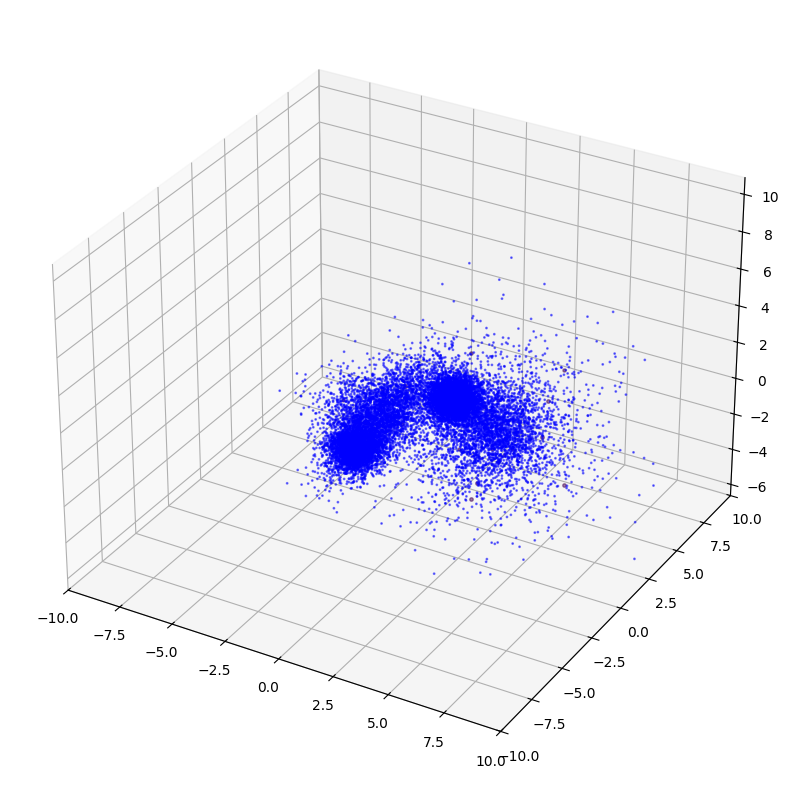

In [243]:
# plotto lo spazio di misura ottenuto:
# evidenzio i cluster con un grafico a barre
# ogni barra ha un'altezza proporzionale al peso del cluster e un ampiezza proporzionale alla misura
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


plt.figure(figsize=(10, 10))

# aggiungo gli scatter fused_d in blu
plt.scatter(fused_d[:, 0].cpu(), fused_d[:, 1].cpu(), color='blue', alpha=0.5, s=2)

for i in range(n_clusters):
    # creo una sfera con raggio proporzionale alla misura
    # il suo colore dipende da weights ed è indicato con color
    circle = Circle(
        centers[i].cpu().numpy(),
        measure[i].item()**(1/fused_d.shape[1]),
        color=(1-weights[i].item(), 0, weights[i].item()),
        alpha=0.8,
    )
    # aggiungo il rettangolo al grafico
    plt.gca().add_patch(circle)


plt.xlim(-10, 10)
plt.ylim(-10, 10)

plt.show()

In [254]:
# fit di A e B su siffatta clusterizzazione
labels_A = fit.predict(A.cpu().numpy().reshape(-1, fused_d.shape[1]))
labels_B = fit.predict(B.cpu().numpy().reshape(-1, fused_d.shape[1]))

# densità di probabilità di A e B sui cluster
p_A = torch.zeros(n_clusters, device=device)
p_B = torch.zeros(n_clusters, device=device)
for i in range(n_clusters):
    p_A[i] = torch.sum(w_A[labels_A == i])
    p_B[i] = torch.sum(w_B[labels_B == i])
p_A /= torch.sum(p_A)
p_B /= torch.sum(p_B)

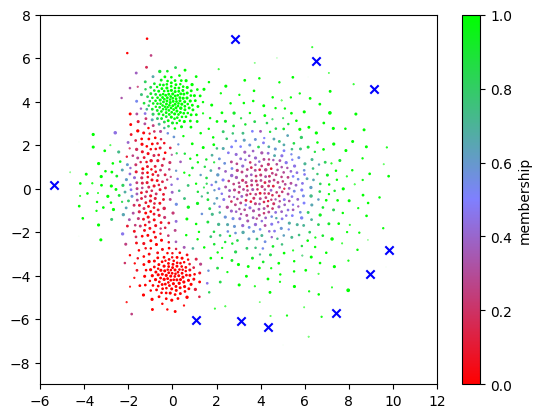

In [206]:
# plotto le densità
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

# colormap
colors = [(1, 0, 0), (0.5, 0.5, 1), (0, 1, 0)]
n_bins = 256  # numero di intervalli nella colormap
cmap_name = 'membership_colormap'
my_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

fig, ax = plt.subplots()  # Crea una figura e un asse
for i in range(n_clusters):
    if measure[i] == 0:
        # metto una X blu per i cluster vuoti
        ax.scatter(centers[i,0].item(), centers[i,1].item(), marker='x', color='blue')
    else:
        # calcolo l'addendo senza elevare al quadrato
        s = ((p_A[i] - p_B[i])/(p_A[i] + p_B[i]))
        s = (s + 1)/2
        # creo un cerchio per il cluster i-esimo
        circ = Circle(
            centers[i].cpu(),
            measure[i].item()**(1/fused_d.shape[1]),
            color=my_cmap(s.cpu()),
            alpha=1.0,
        )
        # aggiungo il rettangolo al grafico
        ax.add_patch(circ)

# inserisco la mappa di colori
# Crea manualmente la colorbar
norm = plt.Normalize(vmin=0, vmax=1)
sm = cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)  # Associa la colorbar all'asse 'ax'
cbar.set_label('membership')

plt.xlim(-6, 12)
plt.ylim(-9, 8)

plt.show()

In [255]:
# ne calcolo la distanza
D_A = p_A > 0
D_B = p_B > 0

integral = torch.where(D_A | D_B, measure * ((p_A-p_B)/(p_A+p_B))**2, torch.zeros(n_clusters, device=device)).sum() / measure[D_A | D_B].sum()
Jaccard_index = measure[D_A & D_B].sum() / measure[D_A | D_B].sum()

distance = (1 + Jaccard_index)**(-1) * integral
print(distance.item())

0.553229570388794


## controprova senza clustering

In [230]:
nodes_perdim = 32

# centri dei cluster sono una meshgrid
centers = torch.meshgrid([torch.linspace(-6, 12, nodes_perdim), torch.linspace(-9, 8, nodes_perdim)])
x_radius = 9 / nodes_perdim
y_radius = 8.5 / nodes_perdim

# la misura è unica e uguale per tutti quindi non serve
# calcolo le densità di probabilità di A e B sui cluster
p_A = torch.zeros((nodes_perdim,nodes_perdim), device=device)
p_B = torch.zeros((nodes_perdim,nodes_perdim), device=device)
for i in range(nodes_perdim):
    for j in range(nodes_perdim):
        # conto quanti punti di A e B sono nel cluster i-esimo, ossia nel range [centers[i]-radius, centers[i]+radius]
        p_A[i,j] = torch.sum(
            (A[:,0] >= centers[0][i,j]-x_radius) & (A[:,0] < centers[0][i,j]+x_radius) &
            (A[:,1] >= centers[1][i,j]-y_radius) & (A[:,1] < centers[1][i,j]+y_radius)
        )
        p_B[i,j] = torch.sum(
            (B[:,0] >= centers[0][i,j]-x_radius) & (B[:,0] < centers[0][i,j]+x_radius) &
            (B[:,1] >= centers[1][i,j]-y_radius) & (B[:,1] < centers[1][i,j]+y_radius)
        )
p_A /= torch.sum(p_A)
p_B /= torch.sum(p_B)

p_A = p_A.view(-1)
p_B = p_B.view(-1)

# calcolo le distanze
D_A = p_A > 0
D_B = p_B > 0
integral = torch.where(D_A | D_B, ((p_A-p_B)/(p_A+p_B))**2, torch.zeros(nodes_perdim*nodes_perdim, device=device)).sum() / torch.count_nonzero(D_A | D_B)
Jaccard_index = torch.count_nonzero(D_A & D_B) / torch.count_nonzero(D_A | D_B)

distance = (1 + Jaccard_index)**(-1) * integral
print(distance.item())

0.48339879512786865


# FFT 2D

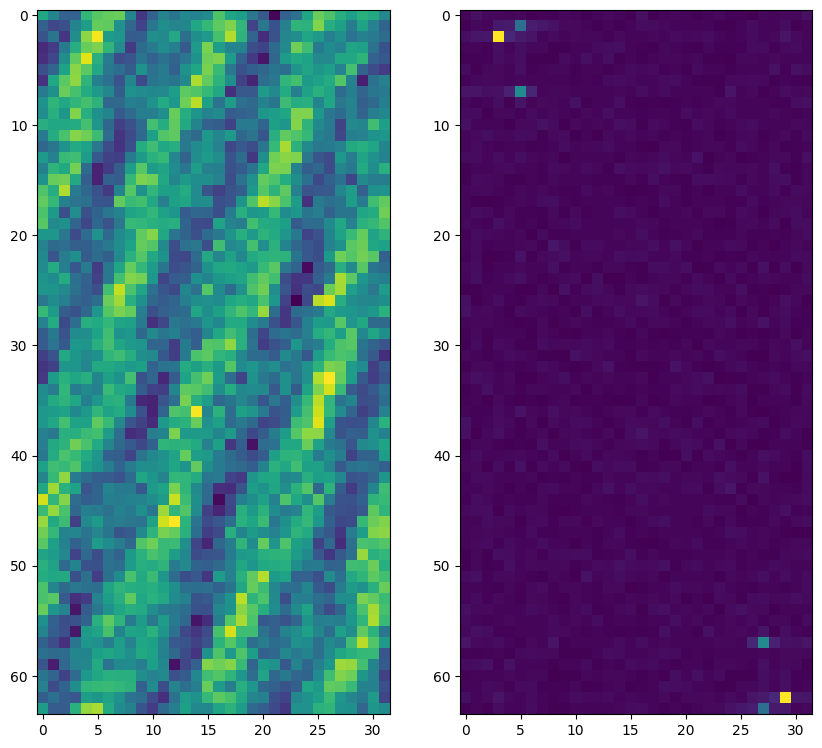

In [26]:
import torch
import math

def my_map(X, Y):
    return 2*torch.cos(2*math.pi*(2*X + 3*Y) + 3) + 0.8*torch.cos(2*math.pi*(X + 5*Y) + 2) + torch.cos(2*math.pi*(7*X + 5*Y)) + torch.randn(X.shape)

# genero X,Y in una matrice 32x16 con valori da 0
X, Y = torch.meshgrid([torch.linspace(0, 1, 64), torch.linspace(0, 1, 32)])

Z = my_map(X,Y)

# calcolo la trasformata di fourier 2d con fft
Z_fft = torch.fft.fft2(Z)

# plotting
from matplotlib import pyplot as plt

# creo 2 plot disposti orizzontalmente
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# in ax[0] mostro la mappa Z
ax[0].imshow(Z.cpu().numpy(), cmap='viridis')

# in ax[1] mostro la mappa Z_fft
ax[1].imshow(torch.abs(Z_fft).cpu().numpy(), cmap='viridis')

plt.show()

In [15]:
L = [{0}]
F = [{1}]

index = 0
for i in range(1,10000):
    for j in range(len(L)-1, -1, -1):
        # controllo se L[j-1] si interseca con F[index] se non si interseca siamo a cavallo
        if not (L[j] & F[index]) and not i in F[j]:
            # i due insiemi non si intersecano
            L[j].add(i)
            F[j].add(i+1)
            F[j].add(i-1)
            index = j
            break
    else:
        # non esiste alcun j valido quindi incremento
        L.append({i})
        F.append({i+1, i-1})
        index = -1

# trasformo in lista ordinata ogni insieme in L
for i in range(len(L)):
    L[i] = sorted(list(L[i]))

for l in L:
    print(l)

[0, 3, 10, 21, 36, 55, 78, 105, 136, 171, 210, 253, 300, 351, 406, 465, 528, 595, 666, 741, 820, 903, 990, 1081, 1176, 1275, 1378, 1485, 1596, 1711, 1830, 1953, 2080, 2211, 2346, 2485, 2628, 2775, 2926, 3081, 3240, 3403, 3570, 3741, 3916, 4095, 4278, 4465, 4656, 4851, 5050, 5253, 5460, 5671, 5886, 6105, 6328, 6555, 6786, 7021, 7260, 7503, 7750, 8001, 8256, 8515, 8778, 9045, 9316, 9591, 9870]
[1, 8, 19, 34, 53, 76, 103, 134, 169, 208, 251, 298, 349, 404, 463, 526, 593, 664, 739, 818, 901, 988, 1079, 1174, 1273, 1376, 1483, 1594, 1709, 1828, 1951, 2078, 2209, 2344, 2483, 2626, 2773, 2924, 3079, 3238, 3401, 3568, 3739, 3914, 4093, 4276, 4463, 4654, 4849, 5048, 5251, 5458, 5669, 5884, 6103, 6326, 6553, 6784, 7019, 7258, 7501, 7748, 7999, 8254, 8513, 8776, 9043, 9314, 9589, 9868]
[2, 5, 17, 32, 51, 74, 101, 132, 167, 206, 249, 296, 347, 402, 461, 524, 591, 662, 737, 816, 899, 986, 1077, 1172, 1271, 1374, 1481, 1592, 1707, 1826, 1949, 2076, 2207, 2342, 2481, 2624, 2771, 2922, 3077, 3236, 339